In [20]:
from pathlib import Path
import dill
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# parent directory to path to import src module
sys.path.insert(0, str(Path.cwd().parent))

import src.unimib_snowit_project.utils as u

OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

In [16]:
DATA_PKL_DIR = 'data_loaded'

USERS_PKL_FILENAME = 'users.pkl'
PROFILES_PKL_FILENAME = 'profiles.pkl'
CARDS_PKL_FILENAME = 'cards.pkl'
ORDERS_PKL_FILENAME = 'orders.pkl'
ORDER_DETAILS_PKL_FILENAME = 'order_details.pkl'

root_dir_path = u.get_root_dir() 

data_pkl_dir_path = root_dir_path / DATA_PKL_DIR
users_pkl_path = data_pkl_dir_path / USERS_PKL_FILENAME
profiles_pkl_path = data_pkl_dir_path / PROFILES_PKL_FILENAME
cards_pkl_path = data_pkl_dir_path / CARDS_PKL_FILENAME
orders_pkl_path = data_pkl_dir_path / ORDERS_PKL_FILENAME
order_details_pkl_path = data_pkl_dir_path / ORDER_DETAILS_PKL_FILENAME

def load_pkl(pkl_path):
    with pkl_path.open('rb') as fh:
        return dill.load(fh)

users_df = load_pkl(users_pkl_path)
profiles_df = load_pkl(profiles_pkl_path)
cards_df = load_pkl(cards_pkl_path)
orders_df = load_pkl(orders_pkl_path)
order_details_df = load_pkl(order_details_pkl_path)

Data Merging and Preparation

In [17]:
# %%
# Convert revenue from item.amount to Euros
# Always compute revenue using order_details_df

order_revenue = (
    order_details_df
    .groupby('order.uid')['item.amount']
    .sum()
    .reset_index()
    .rename(columns={'item.amount': 'amount_paid_eur'})
)

orders_df = pd.merge(
    orders_df,
    order_revenue,
    on='order.uid',
    how='left'
)

# Merge orders with user info
customer_orders_df = pd.merge(
    orders_df,
    users_df,
    on="user.uid",
    how="left"
)

print("Master 'customer_orders_df' created with shape:", customer_orders_df.shape)
customer_orders_df.head()


Master 'customer_orders_df' created with shape: (385168, 27)


,order.uid,user.uid,createdAt_x,createdAtTime,paymentGateway,paymentBrand,pickup,pickupComplete,source_x,tenant,...,referralsCount,city,language,googleId,appleId,facebookId,referral.medium,referral.source,referral.type,favouriteZones
0,4y9zqqvldfqr9n2xnu,nu7fhz41rzwbkabapcufr6g18r,2024-07-01,2024-07-01 19:41:44,stripe,visa,False,False,website,snowit_esterno,...,<NA>,giussano,it,True,<NA>,<NA>,None,None,<NA>,[]
1,i9eovtgp3uxbmesebv,hkxsbgefntzwsodvj3ztvp3gm1,2024-07-01,2024-07-01 08:56:34,discount,None,False,False,website,discovera,...,<NA>,milano,it,<NA>,<NA>,<NA>,None,None,<NA>,[]
2,nsc55zfspubshggcm5,hkxsbgefntzwsodvj3ztvp3gm1,2024-07-01,2024-07-01 08:45:56,discount,None,False,False,website,discovera,...,<NA>,milano,it,<NA>,<NA>,<NA>,None,None,<NA>,[]
3,ltr5f48gwicqwcnzkf,hkxsbgefntzwsodvj3ztvp3gm1,2024-07-01,2024-07-01 08:39:48,discount,None,False,False,website,discovera,...,<NA>,milano,it,<NA>,<NA>,<NA>,None,None,<NA>,[]
4,gxaalzomhfvvdlaxiz,j7dlvmya0aazq8muvzafu1ezmo,2024-07-01,2024-07-01 06:25:39,stripe,mastercard,False,False,website,snowit_esterno,...,<NA>,como,it,<NA>,<NA>,<NA>,None,None,<NA>,[]


 Geographic Analysis: Where is the Revenue Coming From?
 


Top 10 Cities by Total Revenue

--- Analyzing Top 10 Cities by Revenue ---
Top 10 Cities by Total Revenue (€):
city
milano     8378679.16
bergamo     919914.04
brescia     821198.75
monza       686394.99
como         600730.2
genova      449231.52
bologna     402759.68
lecco       382808.86
london      284029.26
firenze     261588.54
Name: amount_paid_eur, dtype: Float64


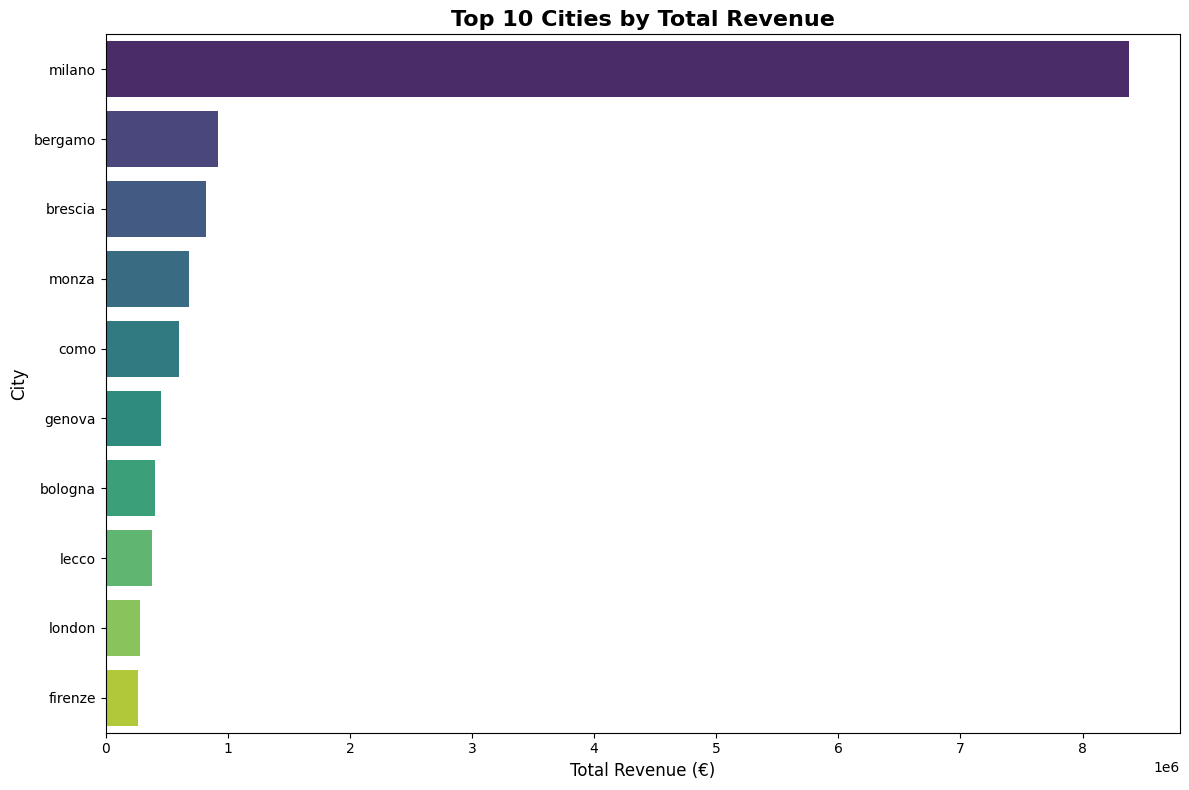

In [18]:
print("--- Analyzing Top 10 Cities by Revenue ---")

# Group by city and sum revenue
revenue_by_city = (
    customer_orders_df
    .dropna(subset=['city', 'amount_paid_eur'])
    .groupby('city')['amount_paid_eur']
    .sum()
    .sort_values(ascending=False)
)

top_10_cities = revenue_by_city.head(10)

print("Top 10 Cities by Total Revenue (€):")
print(top_10_cities.round(2))

# --- Visualization (Warning-free) ---
plt.figure(figsize=(12, 8))

sns.barplot(
    x=top_10_cities.values,
    y=top_10_cities.index,
    hue=top_10_cities.index,   # fixes warning
    palette="viridis",
    legend=False               # avoid redundant legend
)

plt.title('Top 10 Cities by Total Revenue', fontsize=16, weight='bold')
plt.xlabel('Total Revenue (€)', fontsize=12)
plt.ylabel('City', fontsize=12)
plt.tight_layout()

# Show plot
plt.show()

customers' levels by city


--- Deeper Geographic Analysis (Lollipop Chart Version) ---

Top 10 Cities by Number of Unique Customers:
city
milano     30953
brescia     4099
bergamo     3947
monza       2752
como        2317
bologna     1980
lecco       1858
genova      1657
firenze      968
lissone      861
Name: user.uid, dtype: int64


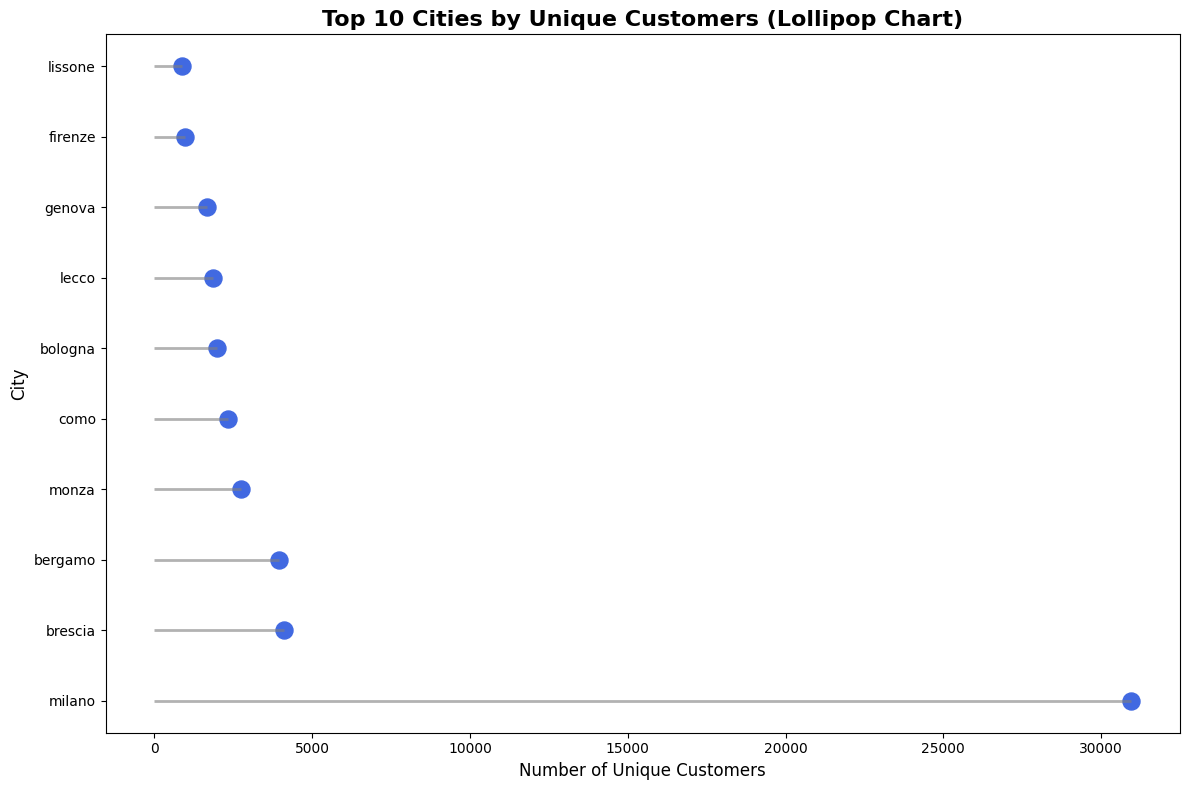

In [22]:
print("\n--- Deeper Geographic Analysis (Lollipop Chart Version) ---")

if 'customer_orders_df' in locals():
    customers_by_city = (
        customer_orders_df.groupby('city')['user.uid']
        .nunique()
        .sort_values(ascending=False)
        .head(10)
    )

    print("\nTop 10 Cities by Number of Unique Customers:")
    print(customers_by_city)

    plt.figure(figsize=(12, 8))

    # Plot stems
    plt.hlines(
        y=customers_by_city.index,
        xmin=0,
        xmax=customers_by_city.values,
        color="gray",
        alpha=0.6,
        linewidth=2
    )

    # Plot points
    plt.scatter(
        customers_by_city.values,
        customers_by_city.index,
        color="royalblue",
        s=150
    )

    plt.title('Top 10 Cities by Unique Customers (Lollipop Chart)', fontsize=16, weight='bold')
    plt.xlabel('Number of Unique Customers', fontsize=12)
    plt.ylabel('City', fontsize=12)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "top_10_cities_by_customers_lollipop.png")
    plt.show()


Orders per customers by city


--- Orders per Customer by City ---

Top 10 Cities by Average Orders Per Customer (Cities with >50 customers):
city
cusago              4.22
chiuduno            4.15
inveruno            4.14
gaggio montano      4.11
albavilla           3.99
eupilio             3.98
casalpusterlengo    3.90
boltiere            3.89
lurate caccivio     3.88
bovisio-masciago    3.88
Name: orders_per_customer, dtype: float64


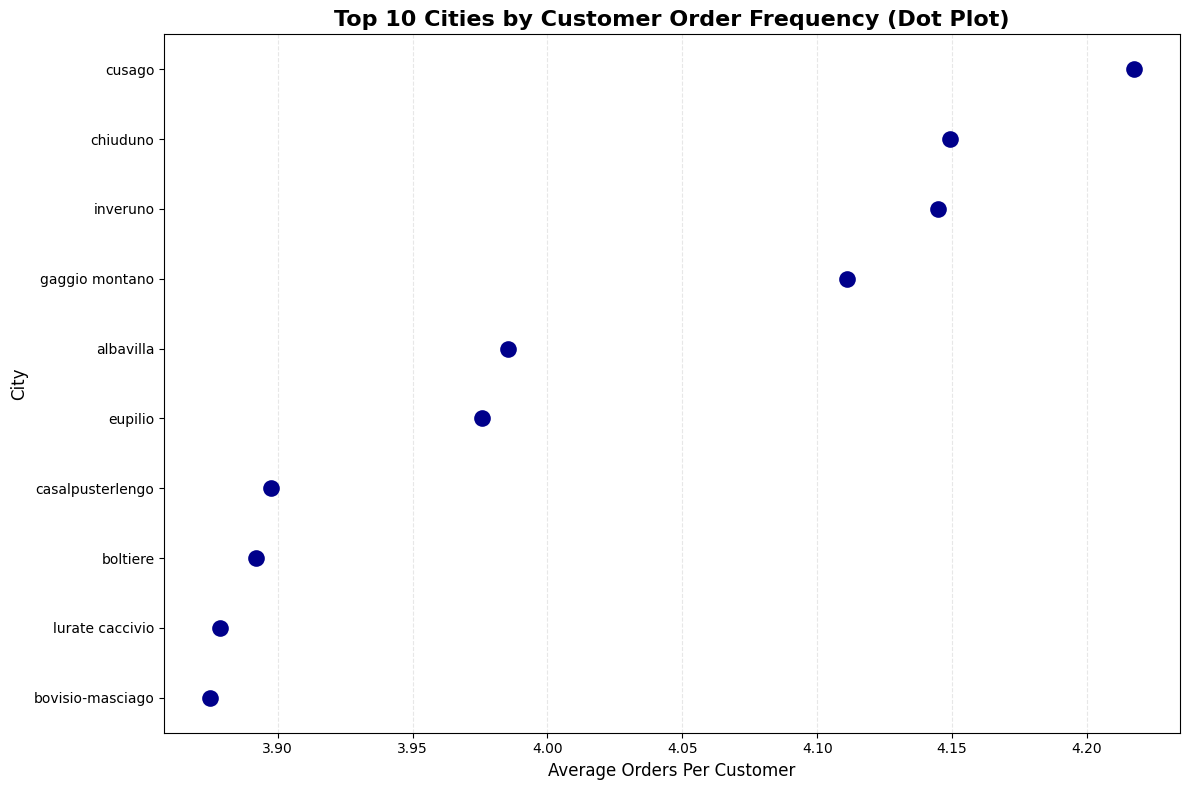

In [23]:
print("\n--- Orders per Customer by City ---")

city_summary = customer_orders_df.groupby('city').agg(
    total_orders=('order.uid', 'count'),
    unique_customers=('user.uid', 'nunique')
).dropna()

city_summary['orders_per_customer'] = (
    city_summary['total_orders'] / city_summary['unique_customers']
)

# Filter for cities with >50 customers
top_cities_by_loyalty = (
    city_summary[city_summary['unique_customers'] > 50]
    .sort_values('orders_per_customer', ascending=False)
    .head(10)
)

print("\nTop 10 Cities by Average Orders Per Customer (Cities with >50 customers):")
print(top_cities_by_loyalty['orders_per_customer'].round(2))

# DOT PLOT
plt.figure(figsize=(12, 8))

sns.stripplot(
    x=top_cities_by_loyalty['orders_per_customer'],
    y=top_cities_by_loyalty.index,
    size=12,
    color="darkblue",
    orient="h"
)

plt.title('Top 10 Cities by Customer Order Frequency (Dot Plot)', fontsize=16, weight='bold')
plt.xlabel('Average Orders Per Customer', fontsize=12)
plt.ylabel('City', fontsize=12)

plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()

plt.savefig(OUTPUT_DIR / "top_10_cities_by_order_frequency_dotplot.png")
plt.show()

Customer Behavior Analysis: One-Time vs. Repeat Customers

Are we acquiring new customers who never return, or are we building a loyal base?


--- Analyzing Customer Purchase Frequency ---
Total customers with at least one order: 161266
Number of one-time buyers: 93617 (58.1%)
Number of repeat customers: 67649 (41.9%)


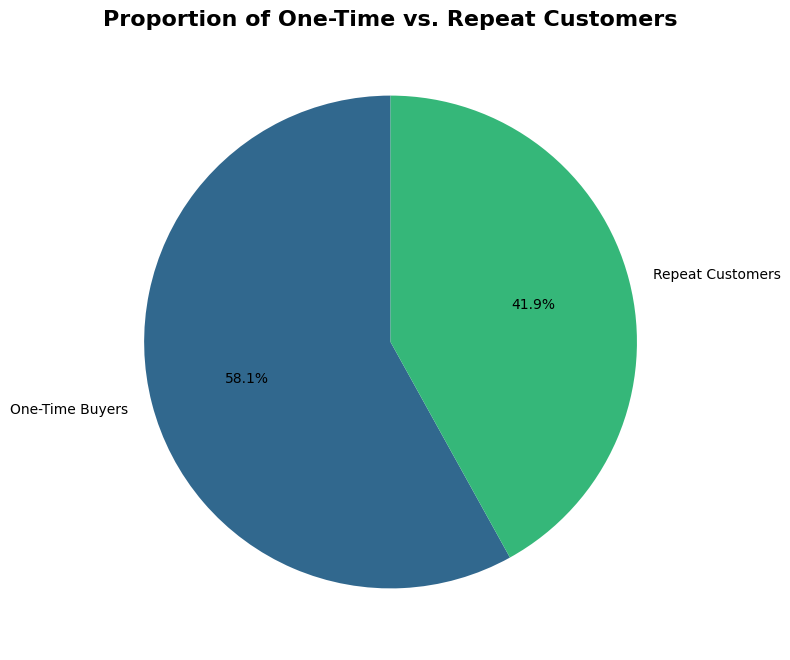

In [24]:
# Ensure OUTPUT_DIR exists
from pathlib import Path
OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

print("\n--- Analyzing Customer Purchase Frequency ---")

# Count orders per user
orders_per_customer = (
    customer_orders_df
    .dropna(subset=['user.uid'])['user.uid']
    .value_counts()
)

# Categorize customers
one_time_buyers = (orders_per_customer == 1).sum()
repeat_customers = (orders_per_customer > 1).sum()
total_customers = len(orders_per_customer)

print(f"Total customers with at least one order: {total_customers}")
print(f"Number of one-time buyers: {one_time_buyers} ({one_time_buyers/total_customers:.1%})")
print(f"Number of repeat customers: {repeat_customers} ({repeat_customers/total_customers:.1%})")

# --- Visualization ---
plt.figure(figsize=(8, 8))
plt.pie(
    [one_time_buyers, repeat_customers],
    labels=['One-Time Buyers', 'Repeat Customers'],
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("viridis", 2)
)
plt.title('Proportion of One-Time vs. Repeat Customers', fontsize=16, weight='bold')

# Save figure
plt.savefig(OUTPUT_DIR / "one_time_vs_repeat_customers.png")

plt.show()



Age Distribution

Age KPIs:
Mean age: 27.84
Median age: 26.00
Mode age: [21.]


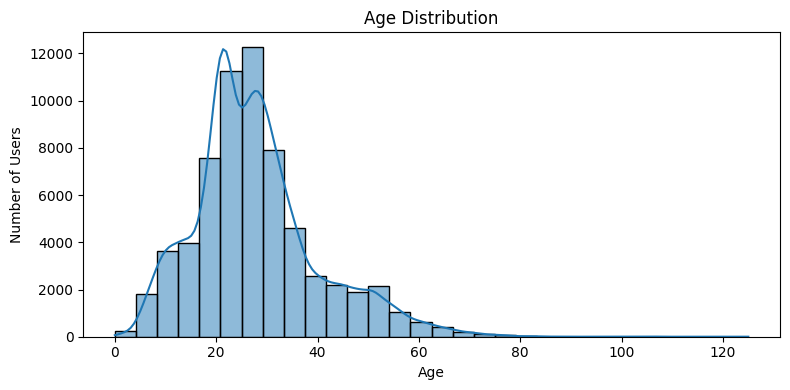

In [25]:
print("Age KPIs:")

# Calculate age from birthday in profiles_df
from datetime import datetime
profiles_df['age'] = (datetime.now() - pd.to_datetime(profiles_df['birthday'])).dt.days // 365

print(f"Mean age: {profiles_df['age'].mean():.2f}")
print(f"Median age: {profiles_df['age'].median():.2f}")
print(f"Mode age: {profiles_df['age'].mode().values}")

plt.figure(figsize=(8, 4))
sns.histplot(profiles_df['age'].dropna(), bins=30, kde=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "age_distribution.png")
plt.show()


Gender Distribution (%):
sex
M    58.85
F    41.15
Name: proportion, dtype: float64


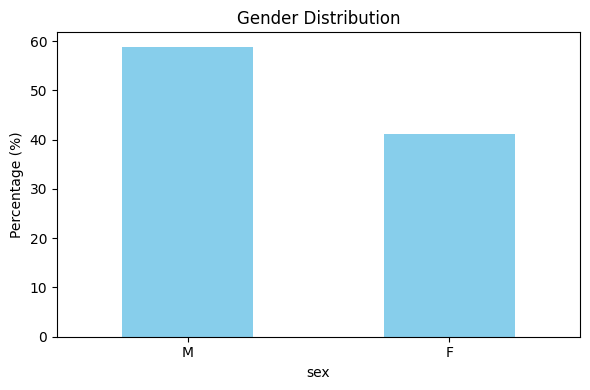

In [26]:
# Use the profiles_df (contains 'sex') instead of undefined 'df'
if 'profiles_df' in locals() and 'sex' in profiles_df.columns:
	gender_counts = profiles_df['sex'].dropna().value_counts(normalize=True) * 100

	print("\nGender Distribution (%):")
	print(gender_counts.round(2))

	plt.figure(figsize=(6, 4))
	gender_counts.plot(kind='bar', color='skyblue')
	plt.title("Gender Distribution")
	plt.ylabel("Percentage (%)")
	plt.xticks(rotation=0)
	plt.tight_layout()

	# save figure if OUTPUT_DIR is available
	if 'OUTPUT_DIR' in locals():
		plt.savefig(OUTPUT_DIR / "gender_distribution.png")

	plt.show()
else:
	raise NameError("profiles_df with column 'sex' not found in the notebook environment.")

Product Performance Analysis: Revenue by Product Type

Which product categories are driving the most revenue?


--- Analyzing Revenue by Product Type (Line Chart) ---
Total Revenue by Product Type:
product.type
skipass                        29103648.00
skipass~membership-seasonal     1530760.00
bundle                          1339147.39
insurance                       1239625.00
rental                           765308.50
coupon                           520891.50
skipass~return                   372479.64
skipass~hotel                    301976.89
hotel                            278258.15
experience                       239308.00
bundle~train                     214832.65
bundle~travel                    158938.00
lesson                           141130.75
seasonal                         116209.00
skipass~membership                90955.00
transport                         83754.15
voucher~skipass                   53610.00
giftcard                          48200.00
bundle~dynamic                    28627.50
rental~bike                       18003.77
skipass~dynamic                   15907.

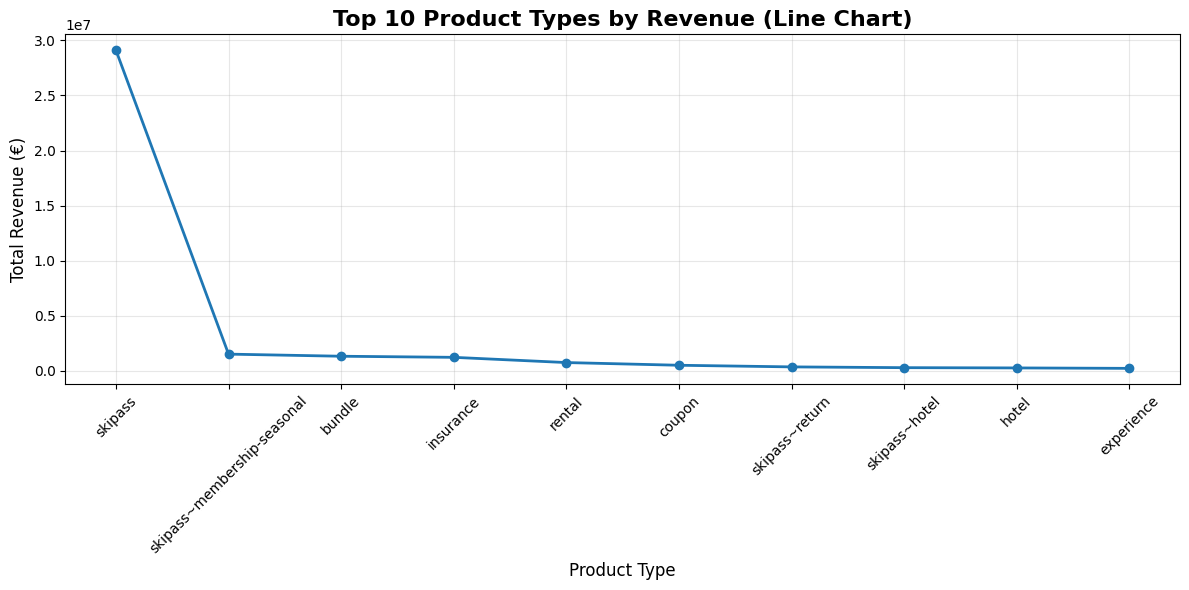

In [27]:
print("\n--- Analyzing Revenue by Product Type (Line Chart) ---")

# Ensure OUTPUT_DIR exists
from pathlib import Path
OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

# 1. Ensure numeric item.amount
order_details_df["item.amount"] = order_details_df["item.amount"].astype(float)

# 2. Filter fulfilled items only 
if "item.status" in order_details_df.columns:
    revenue_source = order_details_df[order_details_df["item.status"] == "fulfilled"]
else:
    revenue_source = order_details_df

# 3. Check product.type
if "product.type" not in revenue_source.columns:
    raise KeyError("Column 'product.type' not found in order_details_df. "
                   "Run order_details_df.columns to inspect columns.")

# 4. Compute revenue by product type
revenue_by_product_type = (
    revenue_source
    .groupby("product.type")["item.amount"]
    .sum()
    .sort_values(ascending=False)
)

print("Total Revenue by Product Type:")
print(revenue_by_product_type.round(2))

# 5. Prepare for line graph
top_10 = revenue_by_product_type.head(10)

# Convert to a DataFrame with a sequential index for line plotting
plot_df = top_10.reset_index()
plot_df.columns = ["product_type", "revenue"]

# 6. Visualization — Line Graph
plt.figure(figsize=(12, 6))
plt.plot(
    plot_df["product_type"],
    plot_df["revenue"],
    marker="o",
    linewidth=2,
    color="tab:blue"
)

plt.title("Top 10 Product Types by Revenue (Line Chart)", fontsize=16, weight="bold")
plt.xlabel("Product Type", fontsize=12)
plt.ylabel("Total Revenue (€)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig(OUTPUT_DIR / "top_10_product_types_line_chart.png")
plt.show()


Revenue and Orders by Source


---Revenue and Orders by Source ---
Using 'source_x' as source column.

Total Revenue by Source (€):
source_x
website    28142967.46
app        13039025.27
Name: amount_paid_eur, dtype: Float64


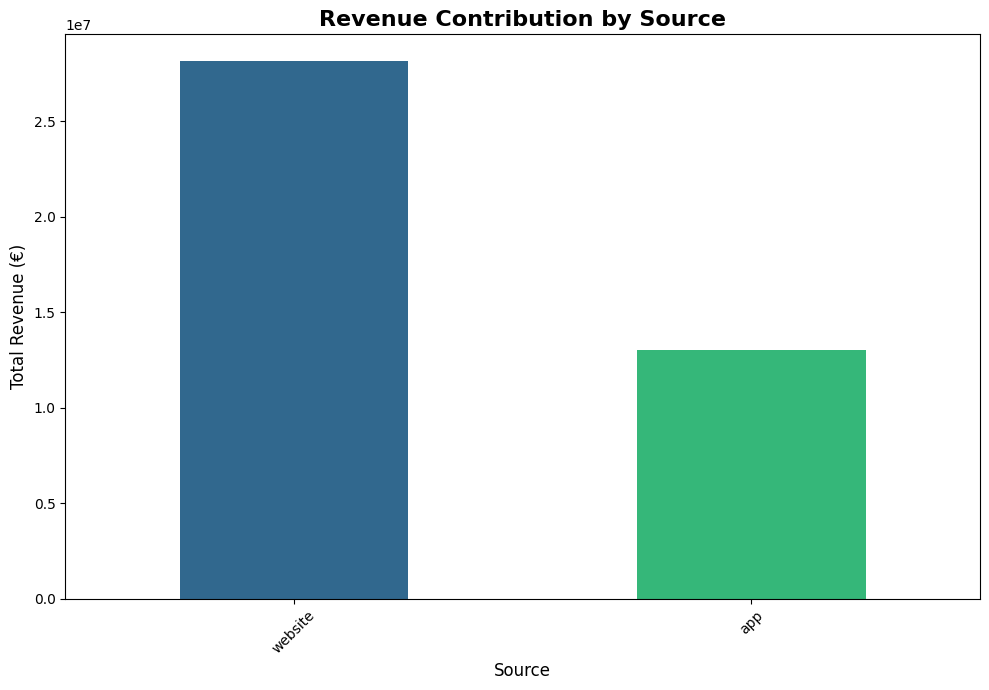

In [28]:
print("\n---Revenue and Orders by Source ---")

if 'customer_orders_df' in locals():
    # Try to find a suitable "source" column
    possible_source_cols = [c for c in customer_orders_df.columns
                            if any(k in c.lower() for k in ["source", "channel", "platform", "origin"])]

    if possible_source_cols:
        source_col = possible_source_cols[0]   # pick the first match
        print(f"Using '{source_col}' as source column.")

        # a. Revenue by Source
        revenue_by_source = (
            customer_orders_df
            .groupby(source_col)['amount_paid_eur']
            .sum()
            .sort_values(ascending=False)   # <-- FIXED HERE
        )

        print("\nTotal Revenue by Source (€):")
        print(revenue_by_source.round(2))

        # Vertical bar chart
        plt.figure(figsize=(10, 7))
        revenue_by_source.plot(kind='bar', color=sns.color_palette("viridis", len(revenue_by_source)))

        plt.title('Revenue Contribution by Source', fontsize=16, weight='bold')
        plt.xlabel('Source', fontsize=12)
        plt.ylabel('Total Revenue (€)', fontsize=12)
        plt.xticks(rotation=45)
        plt.tight_layout()

        plt.savefig(OUTPUT_DIR / "revenue_by_source_bar_vertical.png")
        plt.show()
    


REGISTRATION SOURCE


 Registration Source Distribution (%):
source
website         64.8
app            21.86
terze_parti     9.81
welfare         3.53
Name: proportion, dtype: Float64


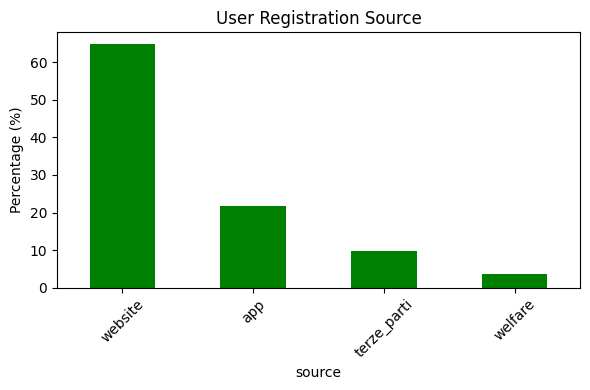

In [29]:
source_counts = users_df['source'].dropna().value_counts(normalize=True) * 100
print("\n Registration Source Distribution (%):")
print(source_counts.round(2))

plt.figure(figsize=(6, 4))
source_counts.plot(kind='bar', color='green')
plt.title("User Registration Source")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Order Volume by Time


- Order Volume by Time ---
Order volume (monthly) — sample:
createdAt
2022-07-31     547
2022-08-31     316
2022-09-30      93
2022-10-31     358
2022-11-30    2912
Freq: ME, dtype: int64


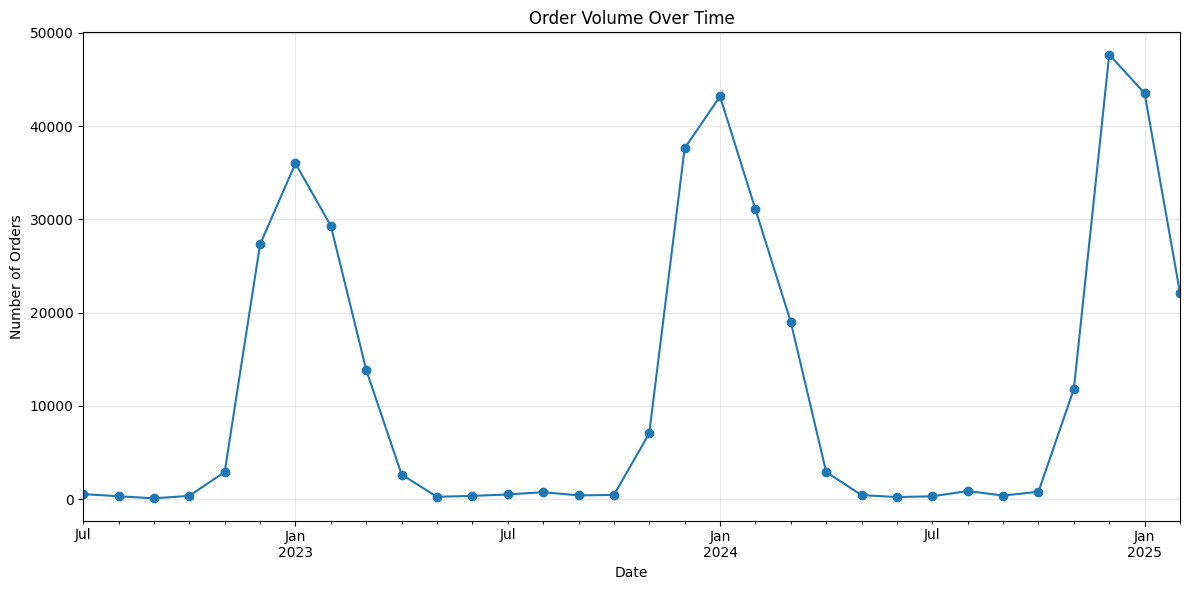

In [31]:
# %%
print("\n- Order Volume by Time ---")

# Use the already-loaded orders_df if present in the notebook environment
if 'orders_df' in locals():
    orders_ts = orders_df.copy()

    # Pick a suitable datetime column from the orders dataframe
    for candidate in ['createdAt', 'createdAtTime', 'order_date', 'created_at']:
        if candidate in orders_ts.columns:
            date_col = candidate
            break

    # Ensure datetime and drop nulls
    orders_ts[date_col] = pd.to_datetime(orders_ts[date_col], errors='coerce')
    orders_ts = orders_ts.dropna(subset=[date_col])

    # Set index to the datetime column
    orders_ts = orders_ts.set_index(date_col)

    # Aggregate order counts by month (change 'M' to 'W' or 'D' for different granularity)
    order_volume = orders_ts.resample('ME').size()

    print("Order volume (monthly) — sample:")
    print(order_volume.head())

    # Plot
    plt.figure(figsize=(12, 6))
    order_volume.plot(marker='o', linestyle='-')
    plt.title('Order Volume Over Time')
    plt.ylabel('Number of Orders')
    plt.xlabel('Date')
    plt.grid(alpha=0.3)
    plt.tight_layout()

    # Save and show
    plt.savefig(OUTPUT_DIR / "order_volume_over_time.png")
    plt.show()

prefered Language


 Top Languages Used:
language
it    462976
en     29096
de      1061
fr        58
sv        11
nl        11
zh         9
es         8
cs         6
ru         5
Name: count, dtype: Int64


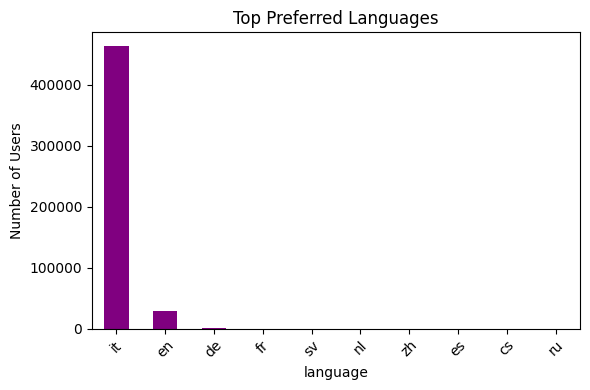

In [32]:
# Use the already-loaded users_df dataframe (not 'df')
lang_counts = users_df['language'].value_counts().head(10)
print("\n Top Languages Used:")
print(lang_counts)

plt.figure(figsize=(6, 4))
lang_counts.plot(kind='bar', color='purple')
plt.title("Top Preferred Languages")
plt.ylabel("Number of Users")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()